In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [21]:
#load the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

In [27]:
batch_size = 64
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [28]:
class_list = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_num = len(class_list)

In [29]:
#visualize the dataset
def imshow(dataloader):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    img = torchvision.utils.make_grid(images)
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


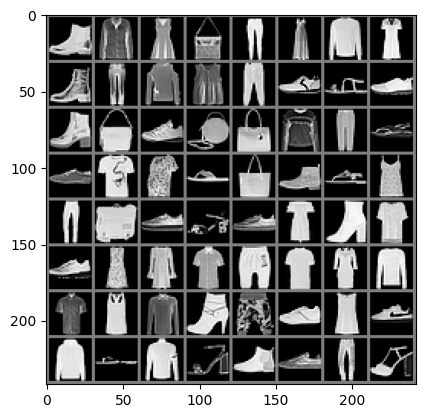

In [30]:
imshow(trainloader)

In [31]:
for images, labels in trainloader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [88]:
#Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.embed = nn.Embedding(class_num, 100)
        #output size = batch_size x 1x 28 x 28
        self.sequential = nn.Sequential(
            nn.ConvTranspose2d(200, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            #flatten
            nn.Flatten(),
            nn.LazyLinear(784),
            nn.Tanh()
        )
    def forward(self, x, label):
        label = self.embed(label)
        label = label.view(label.size(0), label.size(1), 1, 1)
        x = torch.cat((x, label), 1)
        x = self.sequential(x)
        x = x.view(x.size(0), 1, 28, 28)
        return x

In [89]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [92]:
generator = Generator().to(device)

In [93]:
#feed a random noise and a label to the generator
noise = torch.randn(64, 100, 1, 1, device=device)
label = torch.randint(0, 10, (64,), device=device)
fake_image = generator(noise, label)
print(fake_image.shape)

torch.Size([64, 1, 28, 28])


In [107]:
#Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.embed = nn.Embedding(class_num, 100)
        self.sequential = nn.Sequential(
            nn.Conv2d(884, 64, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 3, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            #flatten
            nn.Flatten(),
            nn.LazyLinear(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.LazyLinear(1),
            nn.Sigmoid()
        )
    def forward(self, x, label):
        x = x.view(x.size(0), 28*28, 1, 1)
        label = self.embed(label)
        label = label.view(label.size(0), label.size(1), 1, 1)
        x = torch.cat((x, label), 1)
        x = self.sequential(x)
        return x

In [108]:
discriminator = Discriminator().to(device)

In [110]:
#feed the fake image to the discriminator
output = discriminator(fake_image, label)
print(output.shape)

torch.Size([64, 1])


In [111]:
#training
criterion = nn.BCELoss()
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

In [112]:
#training loop
num_epochs = 10
for epoch in range(num_epochs):
    for i, data in enumerate(trainloader):
        #train discriminator
        discriminator.zero_grad()
        real_image, label = data[0].to(device), data[1].to(device)
        batch_size = real_image.size(0)
        #train discriminator with real image
        real_output = discriminator(real_image, label)
        real_label = torch.ones(batch_size, 1, device=device)
        real_loss = criterion(real_output, real_label)
        real_loss.backward()
        #train discriminator with fake image
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        label = torch.randint(0, 10, (batch_size,), device=device)
        fake_image = generator(noise, label)
        fake_output = discriminator(fake_image.detach(), label)
        fake_label = torch.zeros(batch_size, 1, device=device)
        fake_loss = criterion(fake_output, fake_label)
        fake_loss.backward()
        optimizerD.step()
        #train generator
        generator.zero_grad()
        fake_output = discriminator(fake_image, label)
        real_label = torch.ones(batch_size, 1, device=device)
        generator_loss = criterion(fake_output, real_label)
        generator_loss.backward()
        optimizerG.step()
        #print loss
        if i % 2 == 0:
            print('Epoch: %d, Batch: %d, D_loss: %.4f, G_loss: %.4f' % (epoch, i, real_loss.item() + fake_loss.item(), generator_loss.item()))


Epoch: 0, Batch: 0, D_loss: 1.3988, G_loss: 0.7356
Epoch: 0, Batch: 2, D_loss: 1.3782, G_loss: 0.7361
Epoch: 0, Batch: 4, D_loss: 1.3541, G_loss: 0.7515
Epoch: 0, Batch: 6, D_loss: 1.2763, G_loss: 0.8077
Epoch: 0, Batch: 8, D_loss: 1.2161, G_loss: 0.8563
Epoch: 0, Batch: 10, D_loss: 1.1141, G_loss: 0.9233
Epoch: 0, Batch: 12, D_loss: 1.0297, G_loss: 0.9877
Epoch: 0, Batch: 14, D_loss: 0.9454, G_loss: 1.0736
Epoch: 0, Batch: 16, D_loss: 0.8858, G_loss: 1.1196
Epoch: 0, Batch: 18, D_loss: 0.7914, G_loss: 1.2194
Epoch: 0, Batch: 20, D_loss: 0.7325, G_loss: 1.2766
Epoch: 0, Batch: 22, D_loss: 0.7000, G_loss: 1.3650


KeyboardInterrupt: 

In [113]:
#gernerate image
noise = torch.randn(64, 100, 1, 1, device=device)
label = torch.randint(0, 10, (64,), device=device)
fake_image = generator(noise, label)
fake_image = fake_image.view(fake_image.size(0), 28, 28)
fake_image = fake_image.cpu().detach().numpy()

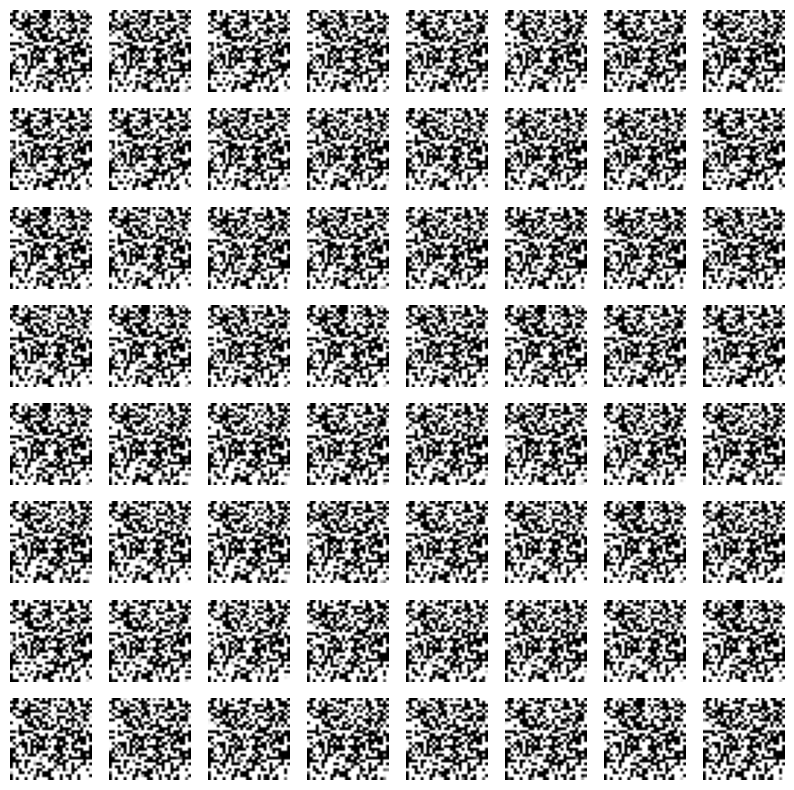

In [114]:
#plot image
plt.figure(figsize=(10, 10))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(fake_image[i], cmap='gray')
    plt.axis('off')
plt.show()